# Twitter Data Preprocessing

Importing all libraries. 

In [210]:
# Imports

import glob
import string

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# nltk
from nltk.tag import pos_tag
import nltk

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Importing Dataset
We import the CSV files

In [174]:
all_data = pd.DataFrame()
for f in glob.glob("./data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [175]:
all_data.info()
all_data = all_data.sample(frac=1).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 20 columns):
id                       2226 non-null float64
id_str                   2226 non-null float64
screen_name              2226 non-null object
location                 1391 non-null object
description              1908 non-null object
url                      1112 non-null object
followers_count          2226 non-null int64
friends_count            2226 non-null int64
listedcount              2226 non-null int64
created_at               2226 non-null object
favourites_count         2226 non-null int64
verified                 2226 non-null bool
statuses_count           2226 non-null int64
lang                     2226 non-null object
status                   2151 non-null object
default_profile          2226 non-null bool
default_profile_image    2226 non-null bool
has_extended_profile     2226 non-null bool
name                     2226 non-null object
bot                      2226 

In [176]:
all_data.head(1)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,6708952.0,6708952.0,SteveCase,Washington DC,Author of The Third Wave: An Entrepreneur's Vi...,https://t.co/fKbrxjPNU4,788439,5297,10473,6/10/07 5:23,0,True,42990,en,"Status(contributors=None, truncated=False, tex...",False,False,False,Steve Case,0


In [177]:
train, test = train_test_split(all_data, test_size = 0.2)

In [178]:
train.shape , test.shape

((1780, 20), (446, 20))

# Visualizing Data

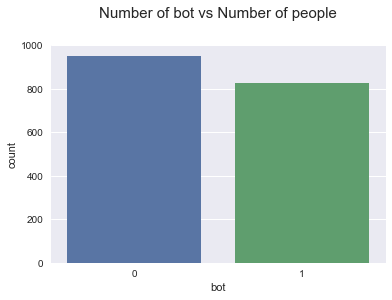

In [7]:
plt.title('Number of bot vs Number of people', y=1.1, size=15)
sns.countplot('bot', data=train)

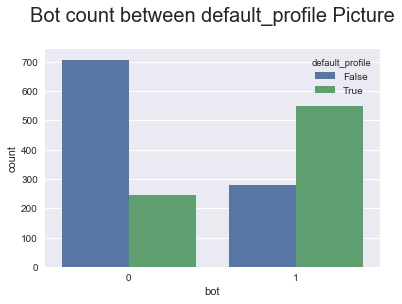

In [9]:
plt.title('Bot count between default_profile Picture', size=20, y=1.1)
sns.countplot(x = 'bot', hue='default_profile', data=train)

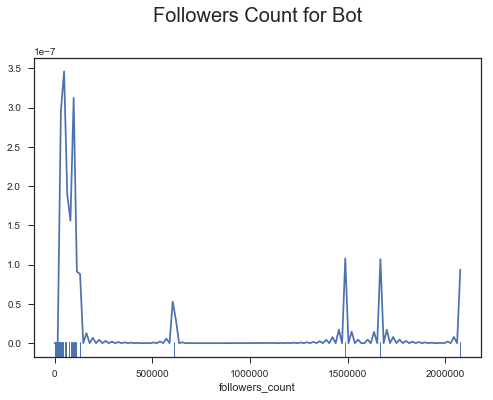

In [32]:
plt.title('Followers Count for Bot', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==1)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

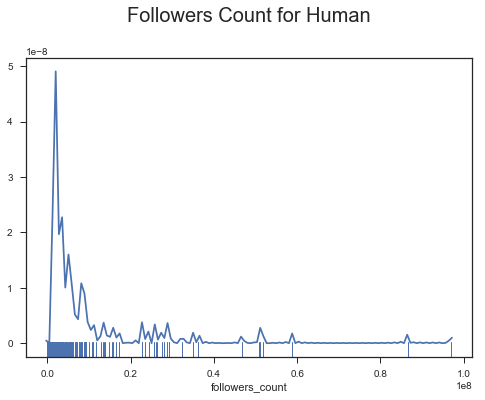

In [33]:
plt.title('Followers Count for Human', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==0)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

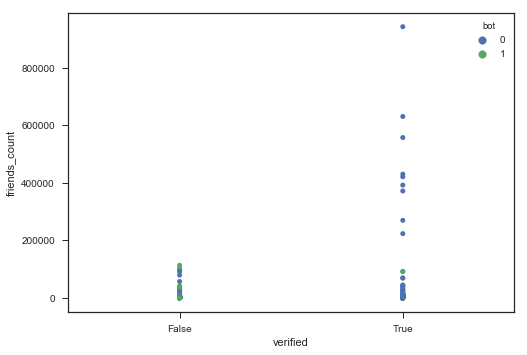

In [44]:
ax = sns.stripplot(x="verified", y="friends_count", hue="bot",data=train)

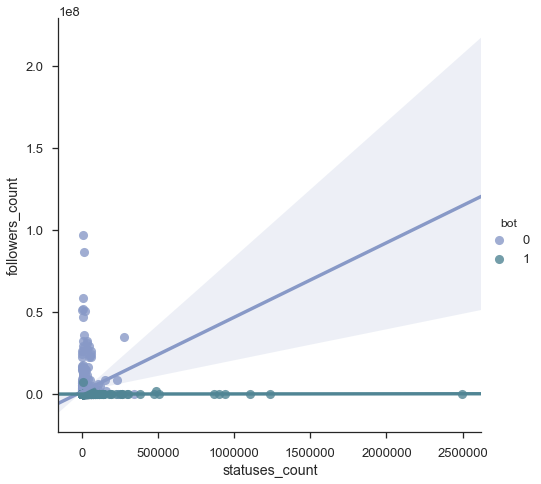

In [34]:
import seaborn as sns
sns.set(style="ticks", context="talk")
pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)
g = sns.lmplot(x="statuses_count", y="followers_count", hue="bot", data=train,
               palette=pal, size=7)
g.set_axis_labels("statuses_count", "followers_count")

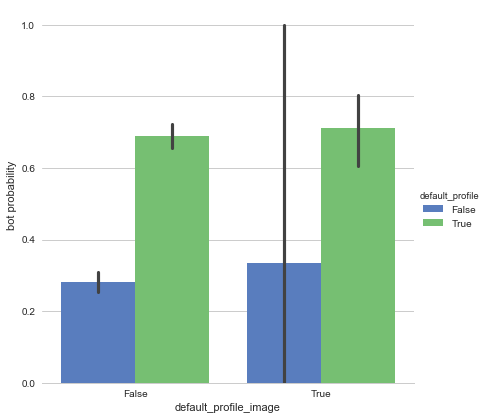

In [40]:
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="default_profile_image", y="bot", hue="default_profile", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("bot probability")

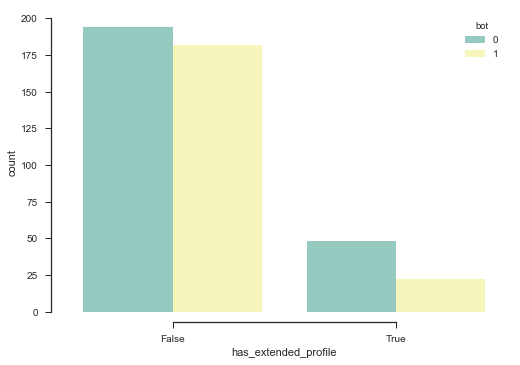

In [20]:
sns.set(style="ticks")
sns.countplot(x="has_extended_profile", hue="bot", data=test, palette="Set3")
sns.despine(offset=10, trim=True)

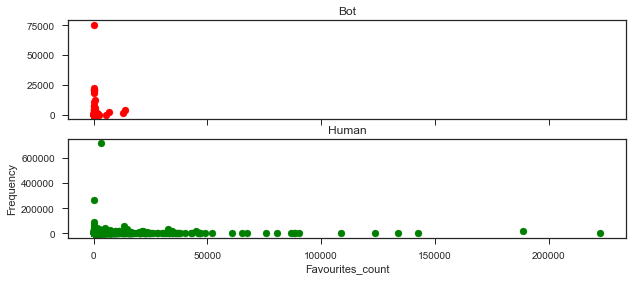

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 2

ax1.scatter(train.listedcount[train.bot == 1],train.favourites_count[train.bot == 1],c='r')
ax1.set_title('Bot')

ax2.scatter( train.listedcount[train.bot == 0],train.favourites_count[train.bot == 0],c='g')
ax2.set_title('Human')

plt.xlabel('Favourites_count')
plt.ylabel('Frequency')
plt.show()

# Transforming Features

In [35]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        time = date_split[1]
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [179]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity

In [180]:
def simplfy_followerscount(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_friendscount(df):
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    return df    

def simplfy_listedcount(df):
    df.loc[:,'listedcount']= df.listedcount.apply(lambda x: int(x)+1)
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang','status','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    return df


def transform_features(df):
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = format_date(df)
    df = diversity(df)
    df = drop_features(df)
    return df

train = transform_features(train)
test = transform_features(test)
train.head()

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,name,bot,modified_date,modified_hour,sn_length,desc_length,diversity,null_url
2073,kazi_quaide,NaN,NaN,1,20,1,1,False,1,True,True,False,Kazi Quaide Azam,1,2017-03-05,14,11,3,0.818182,0
1782,JordinSparks,_��_ Romans 12 _��_ Herbalife _���_��_ https:...,https://t.co/y8tPbfdT0H,4223758,5527,15781,667,True,44964,False,False,False,Jordin Sparks,0,2009-01-26,20,12,75,0.916667,1
271,DanicaPatrick,If you want to get to know me away from the tr...,http://t.co/cx33RX2uyr,1708907,270,13537,121,True,4724,False,False,False,Danica Patrick,0,2009-02-18,23,13,101,0.692308,1
1635,baeksehuniie,free follow from @itskaisehun go follow !,NaN,1557,4868,1,96,False,113,True,False,False,#Read Bio,1,2016-03-11,6,12,41,0.750000,0
903,tbrady14,Silver Fox Pro Rugby Player for @LeicesterTigers,NaN,102773,754,288,1517,True,3735,True,False,False,Tom Brady,0,2012-02-09,22,8,48,1.000000,0


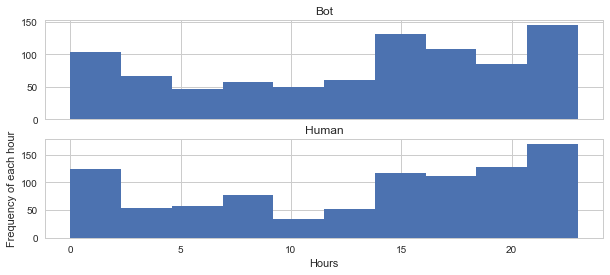

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 30

ax1.hist(train.modified_hour[train.bot == 1])
ax1.set_title('Bot')

ax2.hist(train.modified_hour[train.bot == 0])
ax2.set_title('Human')

plt.xlabel('Hours')
plt.ylabel('Frequency of each hour')
plt.show()

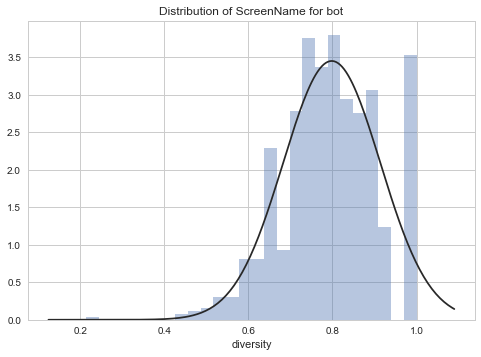

In [74]:
df1 = train[['diversity','bot']]
bot_ = df1.ix[(df1['bot']==1)]
Nonbot_ = df1.ix[(df1['bot']==0)]
from scipy.stats import norm
ax = sns.distplot(bot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for bot')

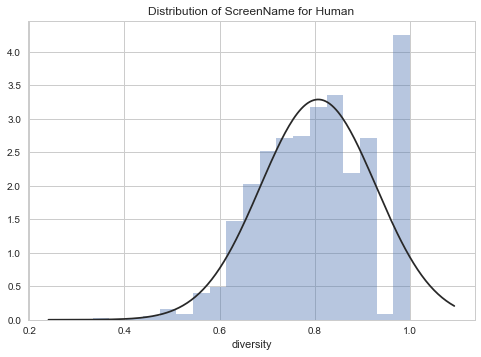

In [75]:
ax = sns.distplot(Nonbot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for Human')

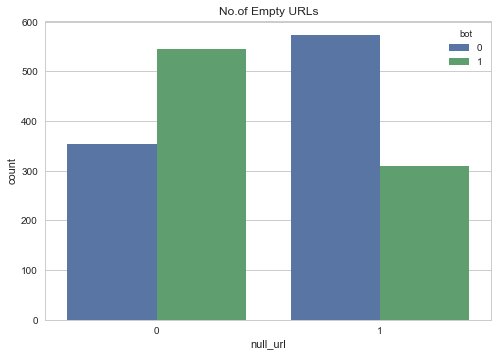

In [66]:
sns.countplot(x ='null_url', hue='bot' ,data=train)
plt.title("No.of Empty URLs")

# Final Encoding

The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.

In [181]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count', \
                'default_profile','default_profile_image','has_extended_profile',\
                'diversity','null_url','modified_hour']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train.loc[:,feature] = le.transform(df_train[feature])
        df_test.loc[:,feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.head()

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,name,bot,modified_date,modified_hour,sn_length,desc_length,diversity,null_url
2073,kazi_quaide,NaN,NaN,0,19,0,0,0,0,1,1,0,Kazi Quaide Azam,1,2017-03-05,14,11,3,30,0
1782,JordinSparks,_��_ Romans 12 _��_ Herbalife _���_��_ https:...,https://t.co/y8tPbfdT0H,1249,914,624,329,1,1539,0,0,0,Jordin Sparks,0,2009-01-26,20,12,75,39,1
271,DanicaPatrick,If you want to get to know me away from the tr...,http://t.co/cx33RX2uyr,1170,241,609,113,1,861,0,0,0,Danica Patrick,0,2009-02-18,23,13,101,20,1
1635,baeksehuniie,free follow from @itskaisehun go follow !,NaN,533,898,0,93,0,99,1,0,0,#Read Bio,1,2016-03-11,6,12,41,25,0
903,tbrady14,Silver Fox Pro Rugby Player for @LeicesterTigers,NaN,954,538,187,466,1,780,1,0,0,Tom Brady,0,2012-02-09,22,8,48,43,0


In [184]:
X_all = train.drop(['screen_name','description','description','url','name','modified_date','bot'], axis=1)
y_all = train['bot']

In [185]:
X_all.shape, y_all.shape

((1780, 14), (1780,))

In [186]:
X_all.head(1)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,modified_hour,sn_length,desc_length,diversity,null_url
2073,0,19,0,0,0,0,1,1,0,14,11,3,30,0


# Feature Selection

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Having too many irrelevant features in your data can decrease the accuracy of the models. Three benefits of performing feature selection before modeling your data are:

* Reduces Overfitting
* Improves Accuracy
* Reduces Training

###  Recursive Feature Elimination
The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain.

Optimal number of features : 6


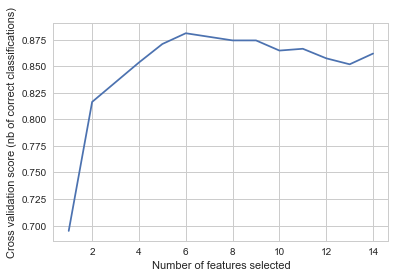

In [187]:
# Create the RFE object and compute a cross-validated score.
model = ExtraTreesClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),scoring='accuracy')
rfecv.fit(X_all, y_all)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

So the optimal number of features to proceed with is 6, will use the DecisionTree and with feature importance function, we can filter out the top 6 features

In [102]:
from sklearn.ensemble import ExtraTreesClassifier
model2 = ExtraTreesClassifier()
model2.fit(X_all, y_all)
print(model2.feature_importances_)

[ 0.12961289  0.12347987  0.09669112  0.14292447  0.1353705   0.08053118
  0.05133882  0.0054922   0.04456585  0.04227766  0.0454382   0.04804867
  0.03747387  0.0167547 ]


In [100]:
list(X_all)

['followers_count',
 'friends_count',
 'listedcount',
 'favourites_count',
 'verified',
 'statuses_count',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'modified_hour',
 'sn_length',
 'desc_length',
 'diversity',
 'null_url']

So after the feature selection, we pick the top 6 features as,
1. followers_count
2. friends_count
3. listedcount
4. favourites_count
5. verified
6. statuses_count

# Models

### Baseline Model

In [108]:
#baseline model
Mcc_pred = all_data
Mcc_pred['pred'] = 0
accuracy_score(Mcc_pred['pred'],Mcc_pred['bot'])

0.52470799640610966

In [191]:
X_train = train.drop(['bot','modified_date','screen_name','description','url','name', 'default_profile',\
                    'default_profile_image','has_extended_profile','modified_hour','sn_length', \
                    'desc_length','diversity','null_url'], axis=1) 
y_train = train['bot']

X_test = test.drop(['bot','modified_date','screen_name','description','url','name', 'default_profile',\
                    'default_profile_image','has_extended_profile','modified_hour','sn_length', \
                    'desc_length','diversity','null_url'], axis=1)
y_test = test['bot']

In [192]:
X_train.shape,  y_train.shape

((1780, 6), (1780,))

In [194]:
X_test.shape, y_test.shape

((446, 6), (446,))

### Decision Tree

In [203]:
# Decision Tree

clf = DecisionTreeClassifier()

parameters = {'max_features': [6], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3, 5, 6], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8],
              'min_impurity_split': [0.00000001, 0.0000001]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_split=1e-08,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [211]:
export_graphviz(clf,out_file='tree.dot') 

In [204]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.865470852018


In [205]:
print np.array(cross_val_score(clf, X_train, y_train, cv=10) ).mean()

0.860594009406


In [201]:
print classification_report(y_test,predictions)

             precision    recall  f1-score   support

          0       0.87      0.89      0.88       243
          1       0.86      0.84      0.85       203

avg / total       0.87      0.87      0.87       446



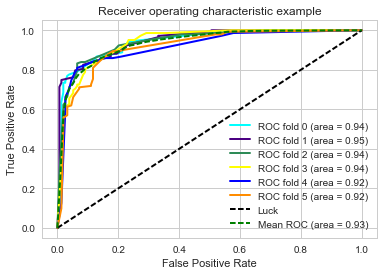

In [207]:
X = X_train.as_matrix()
y = y_train.as_matrix()
n_samples, n_features = X.shape

cv = StratifiedKFold(n_splits=6)
classifier = clf

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [163]:
y_test = np.asarray(y_test)
misclassified = np.where(y_test != clf.predict(X_test) & (y_test == 0))
xx = train.ix[misclassified]
test_mean_bot = train[train['bot'] == 0]
print test_mean_bot.followers_count.mean()
print xx.followers_count.mean()

638.240820734
471.482758621
